# Procedure for quantum state preparation (QSP) experiment.

QSP is presented clearly in [this publication](https://arxiv.org/abs/2306.17422). The basic idea is that we have two unitary $U(\theta)$ and $V^{\dagger}$, we optimize the parameter $\theta$ until $\theta^{*}$ such that $U(\theta^{*})V^{\dagger}=I$.

So we will do experiments with various $U$, $V^{\dagger}$ and optimize strategy. 

Some notation for hyperparameter:

(important)
- Ansatz: $U$ (defined in `qtm.ansatz`)
- Optimize circuit: $u$ (ansatz when repeat $L$ times)
- State: $V^{\dagger}$ (defined in `qtm.state`)
- Number of qubit: $n$ (`num_qubits`)
- Number of layer (for ansatz): $L$ (`num_layers`)
- $\theta$: theta (if $\theta$ is scalar), thetas (if $\theta$ is 1-d numpy array) and thetass (if $\theta$ is 2-d numpy array).

(not important)
- Number of iteration: $n_{iter}$ (`num_iter / iter`)
- Optimizer: `sgd`, `adam` or `qng` family, the best optimizer is `adam`.

Here is your task, run the below codes with:

- $U$ is `qtm.ansatz.g2`, `qtm.ansatz.g2gn` or `qtm.ansatz.g2gnw`.
- $V^{\dagger}$ is `qtm.state.create_GHZ_state(num_qubits).inverse()`, `qtm.state.create_W_state(num_qubits).inverse()`, `qtm.state.create_AME_state(num_qubits).inverse()` or `qtm.state.create_haar_state_inverse(num_qubits)`
- $n$ from 3 - 10 (3 - 5 for AME state).
- $L$ from 1 - 10 (Note: if we run L = 3 and achieve fidelity ~ 0, then no need to run with larger $L$).
- $n_{iter}$: default is 100, if loss value is not ~ 0, you can plot loss_values curve by compiler.plot() method, if it can decrease in the next iteration, then increasing $n_{iter}$ upto 300.

The detailed guideline is below. If you can use the server A6000, let's view `multi_process_script.py`.

In [21]:
import sys
sys.path.insert(0, '..')
from qsee.compilation.qsp import QuantumStatePreparation
from qsee.core import ansatz, state
from qsee.backend import constant, utilities
import matplotlib.pyplot as plt
import numpy as np, qiskit
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


[ 2.09943001e-01 -1.11022302e-16  2.09943001e-01 -0.00000000e+00]
---
[ 0.01708228 -0.01330022  0.01708228 -0.01330022]
---
[-0.03977878 -0.03420063 -0.03977878 -0.03420063]
---
[-0.00370608 -0.03665971 -0.00370608 -0.03665971]
---
[-0.19778297 -0.07759766 -0.19778297 -0.07759766]
---
[0.20579351 0.12417624 0.20579351 0.12417624]
---
[0.21594139 0.02672892 0.21594139 0.02672892]
---
[ 0.07828115 -0.01095371  0.07828115 -0.01095371]
---
[-0.07258224 -0.02247882 -0.07258224 -0.02247882]
---
[ 0.04207099 -0.03803636  0.04207099 -0.03803636]
---
[-0.16049263 -0.03087696 -0.16049263 -0.03087696]
---
[-0.10907843 -0.10408693 -0.10907843 -0.10408693]
---
[0.21777903 0.05567849 0.21777903 0.05567849]
---
[ 0.13743759 -0.00742054  0.13743759 -0.00742054]
---
[-0.05880744 -0.01636226 -0.05880744 -0.01636226]
---
[ 0.00673581 -0.03731341  0.00673581 -0.03731341]
---
[-0.10212048 -0.03254384 -0.10212048 -0.03254384]
---
[-0.16086693 -0.13073018 -0.16086693 -0.13073018]
---
[0.2155334  0.08471581 0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


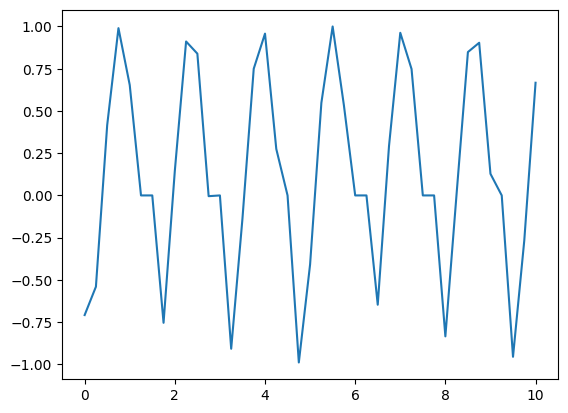

In [92]:
from scipy.linalg import expm
from qiskit.quantum_info import Pauli, Statevector
from qsee.compilation.qsp import QuantumStatePreparation

# Define Pauli matrices
XX = Pauli("XX").to_matrix()
YY = Pauli("YY").to_matrix()
ZZ = Pauli("ZZ").to_matrix()
ZI = Pauli("ZI").to_matrix()
IZ = Pauli("IZ").to_matrix()
# Set coefficients
J = 1.0
D = 0.0
h = 0.0
# Define H
H = J * (XX + YY) + D * ZZ + h * (ZI - IZ)
# define V(t), calculate U and local magnetization
time = np.linspace(0, 10, 41)
magnetization = []

def qsearch_ansatz(num_qubits: int, num_layers):
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    from qiskit.circuit import ParameterVector
    thetas = ParameterVector(
        'theta', 2 * num_layers)
    j = 0
    for _ in range(0, num_layers):
        qc.rx(np.pi / 2, 0)
        qc.rx(np.pi / 2, 1)
        qc.cx(0, 1)
        qc.rx(thetas[j], 0)
        qc.rx(thetas[j + 1], 1)
        qc.cx(0, 1)
        qc.rx(np.pi / 2, 0)
        qc.rx(np.pi / 2, 1)
        j += 2
    return qc
for t in time:
    V = expm(-1j * t * H)
    qc = qiskit.QuantumCircuit(2)
    qc.h(1)
    qc.unitary(V, list(range(0, 2)), label='InputUnita')
    
    compiler = QuantumStatePreparation(u=qsearch_ansatz(2, 2), target_state=qc.inverse()).fit(num_steps = 200)
    statevector = Statevector.from_instruction(
        compiler.u.assign_parameters(compiler.thetas)
    )
    # print(V)
    # print(V)
    # print(compiler.fidelity)
    # print(compiler.thetas)
    print('---')
    psi_t = np.array(statevector.data).reshape(-1, 1)
    psi_t_dag = np.conj(psi_t.T)
    mag = (psi_t_dag @ ZI @ psi_t)[0][0] - (psi_t_dag @ IZ @ psi_t)[0][0]
    magnetization.append(0.5 * mag)

plt.plot(time, magnetization)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


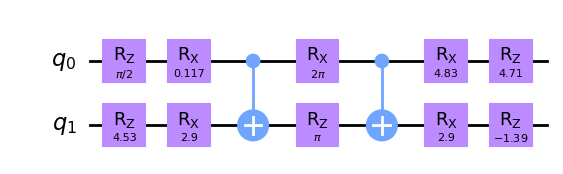

In [94]:
qc = qiskit.QuantumCircuit.from_qasm_file('2q_XY_timestep0.qasm')
qc.draw('mpl', filename='2q_XY_timestep0.eps')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


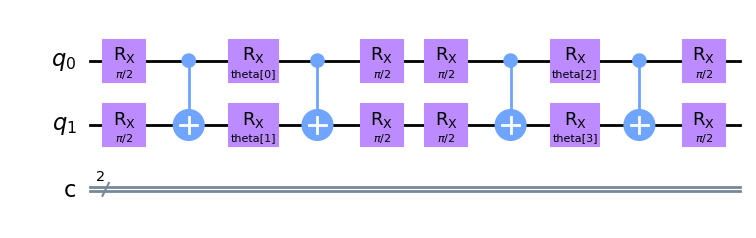

In [93]:
qsearch_ansatz(2, 2).draw('mpl', filename = 'qsearch_ansatz.eps')


In [89]:
np.real(magnetization)

array([-2.29848848e-01, -7.58287877e-11, -6.97694125e-11, -9.07947051e-11,
        6.53631549e-01, -2.83695082e-01, -9.60159981e-01, -2.62327937e-11,
       -3.10074189e-12, -1.61634706e-10,  8.39058163e-01, -4.39315485e-03,
       -8.43833116e-01, -2.78078671e-11, -1.45574663e-11, -8.82960371e-13,
        9.57656677e-01,  2.75208880e-01, -6.60310145e-01, -3.39267402e-06,
       -8.40496561e-11, -1.05730424e-10,  9.99963877e-01,  5.32835464e-01,
       -4.24216100e-01, -9.90856700e-01, -2.57127653e-12, -1.13948850e-11,
       -5.14338572e-11,  7.48041332e-01, -1.54257027e-01, -9.14733705e-01,
       -1.07333586e-10, -1.09129372e-11, -6.79885481e-10,  9.03684665e-01,
        1.28014748e-01, -7.65392417e-01, -1.10976006e-10, -5.76682035e-11,
       -1.96010430e-10])

In [ ]:
plt.plot(time, magnetization)
plt.savefig()

In [46]:
# iSWAP matrix operator
iswap_op = qiskit.quantum_info.Operator([[1, 0, 0, 0],
[0, 0, 1j, 0],
[0, 1j, 0, 0],
[0, 0, 0, 1]])
# CNOT in terms of iSWAP and single-qubit gates
cx_circ = qiskit.QuantumCircuit (2)
cx_circ.unitary(iswap_op, [0, 1], label='iswap')
cx_circ.draw('mpl')
print(qiskit.quantum_info.DensityMatrix.from_instruction(cx_circ))

DensityMatrix([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
              dims=(2, 2))


In [13]:
magnetization

[(-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818305867007623e-17j),
 (-5.646066947306849e-11-2.4818

### Quantum State Preparation (QSP) problem

First, using Quantum Compilation (QC) to find optimized $\theta$

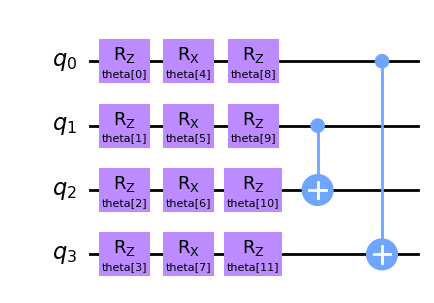

In [46]:
ansatz.zxz_WalternatingCNOT(4, 1).draw(
    'mpl', filename='zxz_walltoallcnot4.eps')

In [3]:
def custom_ansatz(num_qubits: int) -> qiskit.QuantumCircuit:
    qc = qiskit.QuantumCircuit(num_qubits)
    thetas = qiskit.circuit.ParameterVector("theta", 2 * num_qubits)
    j = 0
    for i in range(num_qubits):
        qc.rx(thetas[j], i)
        qc.rz(thetas[j + 1], i)
        j += 2
    return qc


qsp = QuantumStatePreparation(
    u=custom_ansatz(2),
    target_state=state.w(num_qubits=2).inverse(),
).fit(
    num_steps=100,
    optimizer='sgd',
    metrics_func=[
        'loss_basic',
        'compilation_trace_fidelities'
    ]
)

In [5]:
custom_ansatz(3).num_parameters

6

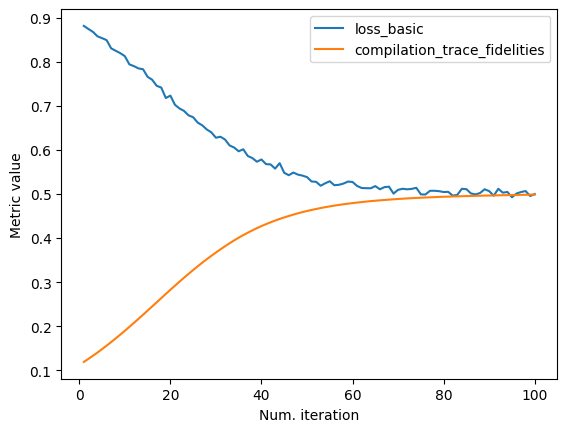

In [10]:
qsp.plot()

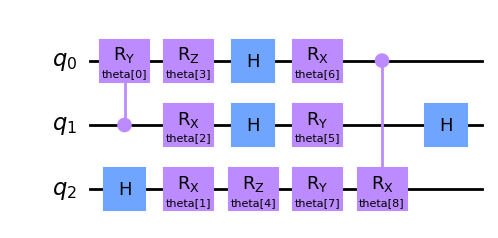

In [19]:
from qsee.core import random_circuit

random_circuit.generate_with_pool(3, 5).draw("mpl")

In [7]:
from qiskit.providers.fake_provider import FakeQasmSimulator
backend = FakeQasmSimulator()
qc = qiskit.QuantumCircuit(3)
target_state = {
    "000": 1 / np.sqrt(2),
    "001": 1j / np.sqrt(6),
    "010": -1j / np.sqrt(3),
    "011": (1 + 1j) / (2 * np.sqrt(2)),
}
qc = state.specific([1 / np.sqrt(2), 1j / np.sqrt(6), -1j / np.sqrt(3), (1 + 1j) / (2 * np.sqrt(2)),
                     0, 0, 0, 0])
qc1 = qiskit.transpile(qc, backend, basis_gates=[
                       'cx', 'rx', 'ry', 'rz', 'h', 'crx', 'cry', 'crz', 'ccz'])
qc1.draw('mpl', filename='custom.eps')

ImportError: cannot import name 'FakeQASMSimulator' from 'qiskit.providers.fake_provider' (/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/providers/fake_provider/__init__.py)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


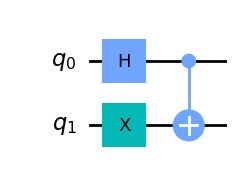

In [5]:
qc = qiskit.QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cx(0, 1)
qc.draw('mpl', filename='w2.eps')

In [42]:
target_state = {
    "000": 1 / np.sqrt(2),
    "001": 1j / np.sqrt(6),
    "010": -1j / np.sqrt(3),
    "011": (1 + 1j) / (2 * np.sqrt(2)),
}
qsp = QuantumStatePreparation(
    u=ansatz.zxz_WchainCNOT(3, 2),
    target_state=target_state,
).fit(
    num_steps=100,
    optimizer="adam",
    metrics_func=["compilation_trace_distances",
                  "compilation_trace_fidelities"],
)

/Users/vutuanhai/Documents/GitHub/ucvqa/codes/../qsee/core/state.py:264: UserWarning: The input state is not normalized, we will normalize it for you
  warnings.warn("The input state is not normalized, we will normalize it for you")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


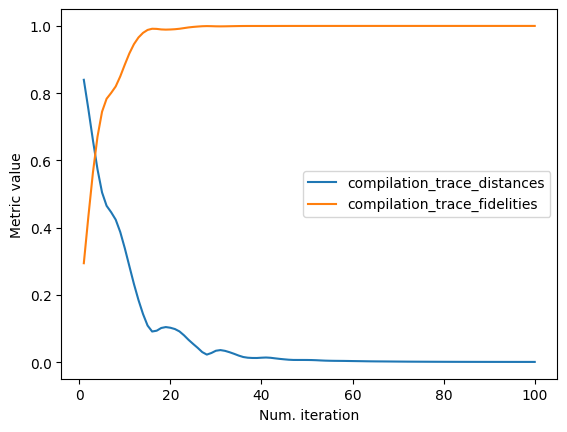

In [44]:
qsp.plot("zxz_wchainCNOT_eq2.eps")

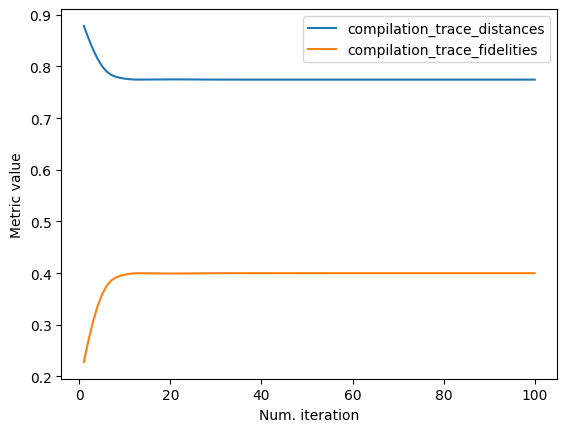

In [41]:
qsp.plot()

In [28]:
np.savetxt("loss4.txt", qsp.compiler.metrics["compilation_trace_fidelities"])

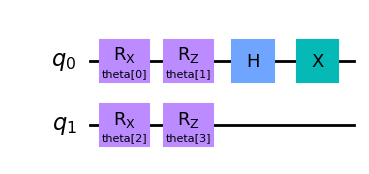

In [11]:
custom_ansatz(num_qubits=2).compose(state.w(num_qubits=2).inverse()).draw(
    "mpl", filename="circuit.svg"
)

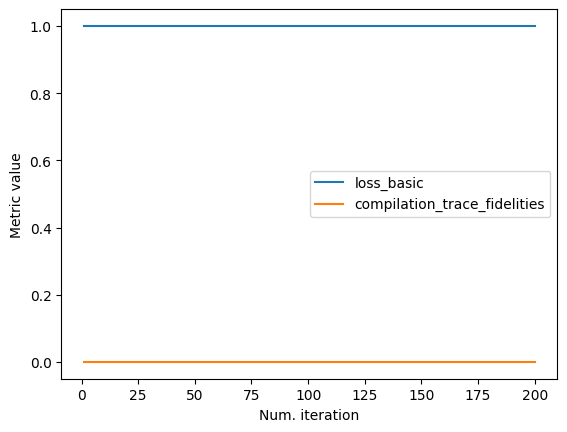

In [174]:
qsp.plot()

In [85]:
theta = np.pi / 2
u = np.array(
    [
        [1, 0, 0, 0],
        [0, np.cos(theta), 0, np.sin(theta)],
        [0, 0, 1, 0],
        [0, np.sin(theta), 0, -np.cos(theta)],
    ]
)
compiler = QuantumStatePreparation.prepare(u)

In [1]:
from qiskit import Aer, QuantumCircuit, transpile, execute
from qiskit.circuit import Parameter
from qiskit.opflow import X, Z, I
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms import VQE
from qiskit.utils import QuantumInstance

# Define the Hamiltonian for the 2-qubit system.
# Example: H = Z_0 + X_1, where Z_0 acts on the first qubit and X_1 on the second qubit
hamiltonian = Z ^ X ^ I ^ I ^ I  # Adding identity operators for unused qubits

# Define the ansatz circuit for the 2 qubits
theta = Parameter('θ')
qc = QuantumCircuit(5)  # Initialize a 5-qubit circuit
# Example ansatz for 2 qubits
qc.rx(theta, 0)  # Rotate the first qubit
qc.ry(theta, 1)  # Rotate the second qubit

# Prepare the backend
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend)

# Setup the VQE
optimizer = COBYLA()
vqe = VQE(ansatz=qc, optimizer=optimizer, quantum_instance=quantum_instance)

# Execute VQE
result = vqe.compute_minimum_eigenvalue(operator=hamiltonian)

print(f"Minimum Eigenvalue: {result.eigenvalue.real}")
print(f"Optimal Parameters: {result.optimal_parameters}")


/var/folders/bw/2cm4rnhn0djgg95n4py1pysc0000gp/T/ipykernel_43191/1120525746.py:3: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import X, Z, I
/var/folders/bw/2cm4rnhn0djgg95n4py1pysc0000gp/T/ipykernel_43191/1120525746.py:4: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA
/var/folders/bw/2cm4rnhn0djgg95n4py1pysc0000gp/T/ipykernel_43191/1120525746.py:21: DeprecationWarning: The class ``qiskit.utils.quantum_insta

Minimum Eigenvalue: 0.0
Optimal Parameters: {Parameter(θ): 3.3873602750679996}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


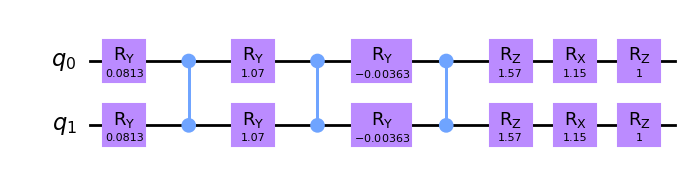

In [77]:
compiler.u.assign_parameters(compiler.thetas).draw("mpl")

In [20]:
num_qubits = 2
num_layers = 1
qsp = QuantumStatePreparation(
    u=ansatz.g2gn(num_qubits, num_layers),
    target_state=state.w(num_qubits=2).inverse(),
).fit(50)

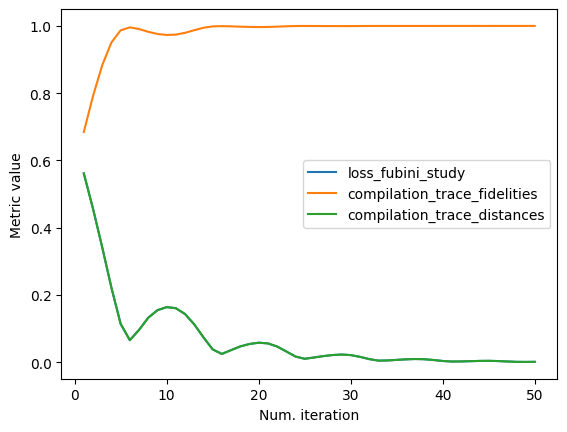

In [21]:
qsp.compiler.plot()

In [143]:
import numpy as np

target_state = {
    "000": 1 / np.sqrt(2),
    "001": 1j / np.sqrt(6),
    "010": -1j / np.sqrt(3),
    "011": (1 + 1j) / (2 * np.sqrt(2)),
}
compiler = QuantumStatePreparation.prepare(target_state)

In [15]:
import numpy as np

target_state = {
    "000": 0.27,
    "001": 0.363,
    "010": 0.326,
    "011": 0,
    "100": 0.377,
    "101": 0,
    "110": 0,
    "111": 0.740*np.exp(-0.79*1j*np.pi)
}

compiler = QuantumStatePreparation.prepare(target_state)

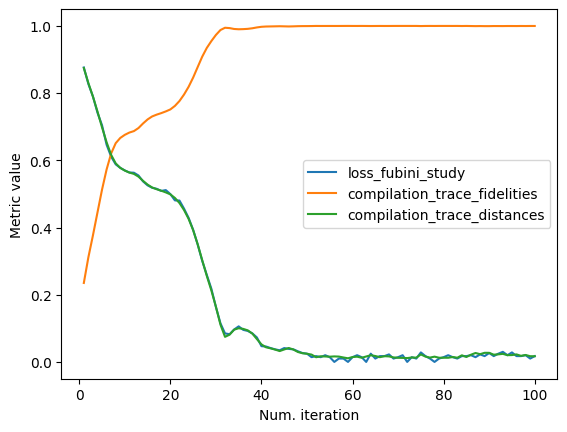

In [16]:
compiler.plot()

In [18]:
num_qubits = 2
num_layers = 1
qsp = QuantumStatePreparation(
    u=compiler.u,
    target_state=state.w(num_qubits=2).inverse(),
).fit()

QiskitError: 'Cannot add shapes width different total left dimension 8 != 4'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


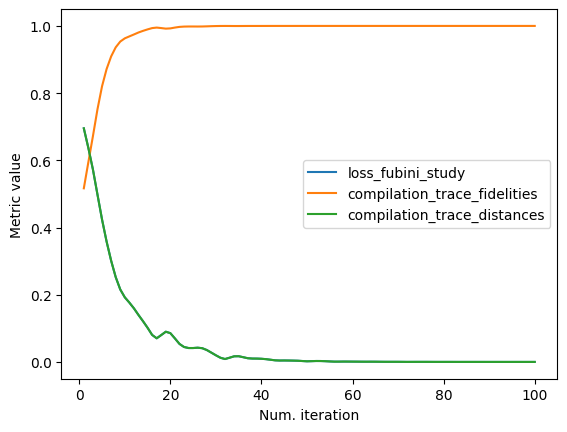

In [46]:
qsp.plot(filename="uw3_plot")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


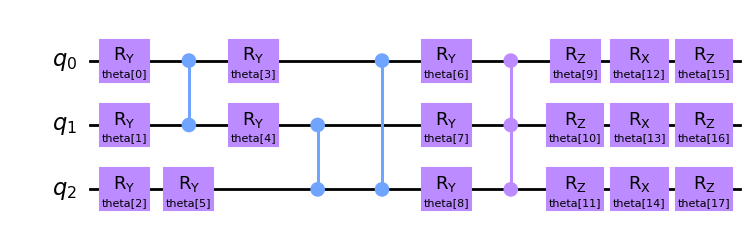

In [146]:
compiler.u.draw("mpl", filename="circuit_psi2.eps")

In [43]:

compiler = QuantumStatePreparation.prepare('w', num_qubits=3, error_rate=0.001)

     ┌──────────────┐                ┌──────────────┐      ┌──────────────┐   
q_0: ┤ Ry(theta[0]) ├───────■────────┤ Ry(theta[3]) ├────■─┤ Ry(theta[6]) ├─■─
     ├──────────────┤       │        ├──────────────┤    │ ├──────────────┤ │ 
q_1: ┤ Ry(theta[1]) ├───────■────────┤ Ry(theta[4]) ├─■──┼─┤ Ry(theta[7]) ├─■─
     ├──────────────┤┌──────────────┐└──────────────┘ │  │ ├──────────────┤ │ 
q_2: ┤ Ry(theta[2]) ├┤ Ry(theta[5]) ├─────────────────■──■─┤ Ry(theta[8]) ├─■─
     └──────────────┘└──────────────┘                      └──────────────┘   
can prepare the state w 3 qubits >= 0.999 fidelity (0.9999561765943481)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


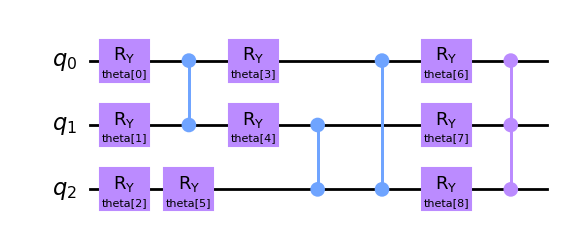

In [44]:
compiler.u.draw('mpl', filename='uw3.eps')

In [48]:
from qsee.compilation.qsp import QuantumStatePreparation

target_state = np.array(np.random.uniform(size=2**3))
compiler = QuantumStatePreparation.prepare(target_state, error_rate=0.1)

Default compiler is not sastify your error rate, please use other ansatz in QuantumCompilationObj


**Important**, you must save the result in the folder experiments/qsp/, where the 'state' argument is the name of state which is need to prepare. The name of file will be automatically create followed this format:

```
[state]_[ansatz]_[num_qubits]_[num_layers].qspobj
```

Last step, load QSP from saved file and check its properties.

In [36]:
qspobj = QuantumStatePreparation.load("../experiments/test")
qspobj.fidelity

0.9998482451406707

In [8]:
obj = QuantumStatePreparation.prepare("ghz", num_qubits=3)

     ┌──────────────┐                ┌──────────────┐      ┌──────────────┐   
q_0: ┤ Ry(theta[0]) ├───────■────────┤ Ry(theta[3]) ├────■─┤ Ry(theta[6]) ├─■─
     ├──────────────┤       │        ├──────────────┤    │ ├──────────────┤ │ 
q_1: ┤ Ry(theta[1]) ├───────■────────┤ Ry(theta[4]) ├─■──┼─┤ Ry(theta[7]) ├─■─
     ├──────────────┤┌──────────────┐└──────────────┘ │  │ ├──────────────┤ │ 
q_2: ┤ Ry(theta[2]) ├┤ Ry(theta[5]) ├─────────────────■──■─┤ Ry(theta[8]) ├─■─
     └──────────────┘└──────────────┘                      └──────────────┘   
can prepare the state ghz 3 qubits >= 0.99 fidelity (0.9998482451406707)


In [35]:
obj.save("../experiments/test")